# Analyize the Serial Killers dataset
Now that the data has been sufficently cleaned, we can begin to analize the data to look for trends.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_csv(r'..\data\serial_killers_wiki_cleaned.csv')

df.head()

,Name,Country,Proven victims,Possible victims,Notes,Start,End,duration,Latitude,Longitude
0,Luis Garavito,Colombia,193,300,"Child-murderer, torture-killer, and rapist kno...",1992,1999,7,4.0,-72.0
1,Pedro López,Colombia,110,300,"Child-murderer and rapist, known as ""The Monst...",1969,1980,11,4.0,-72.0
2,Javed Iqbal,Pakistan,100,100,"Child-murderer and rapist, known as ""Kukri"", I...",1998,1999,1,30.0,70.0
3,Mikhail Popkov,Russia,83,86,"Serial rapist-killer nicknamed ""The Werewolf"",...",1992,2010,18,60.0,100.0
4,Daniel Camargo Barbosa,Colombia,72,180,"Child and woman murderer, believed to have pos...",1974,1986,12,4.0,-72.0


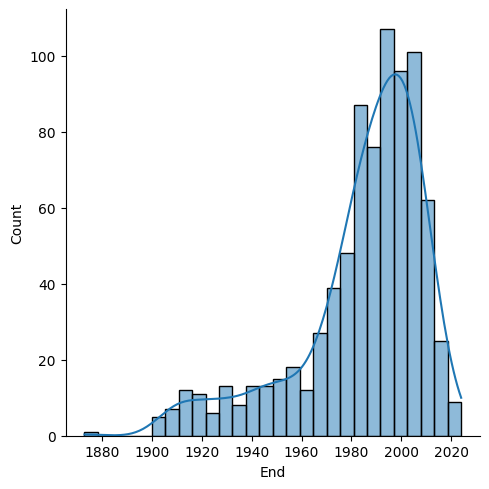

In [9]:
sns.displot(df['End'], kde=True)

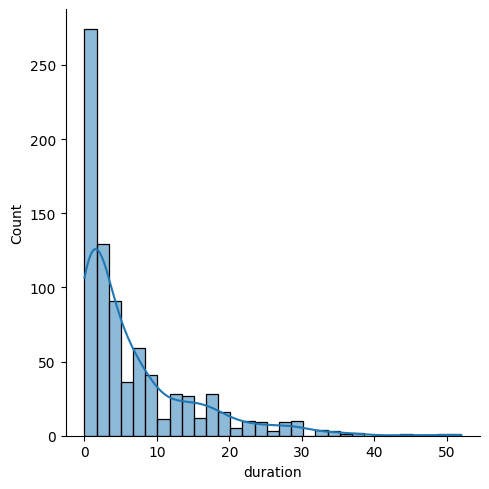

In [13]:
sns.displot(df['duration'], kde=True)

In [14]:
df[['Proven victims', 'duration']].corr()

,Proven victims,duration
Proven victims,1.000000,0.107347
duration,0.107347,1.000000


In [10]:
df[['Proven victims', 'Possible victims', 'Start', 'End', 'duration']].describe()

,Proven victims,Possible victims,Start,End,duration
count,811.000000,811.000000,811.000000,811.000000,811.000000
mean,12.198520,24.794081,1977.759556,1984.452528,6.692972
std,22.568333,71.516368,26.520482,25.547364,8.084931
min,0.000000,0.000000,1871.000000,1873.000000,0.000000
25%,4.000000,0.000000,1969.000000,1976.000000,1.000000
50%,7.000000,10.000000,1984.000000,1991.000000,4.000000
75%,13.000000,20.000000,1996.000000,2002.000000,9.000000
max,400.000000,1200.000000,2023.000000,2024.000000,52.000000


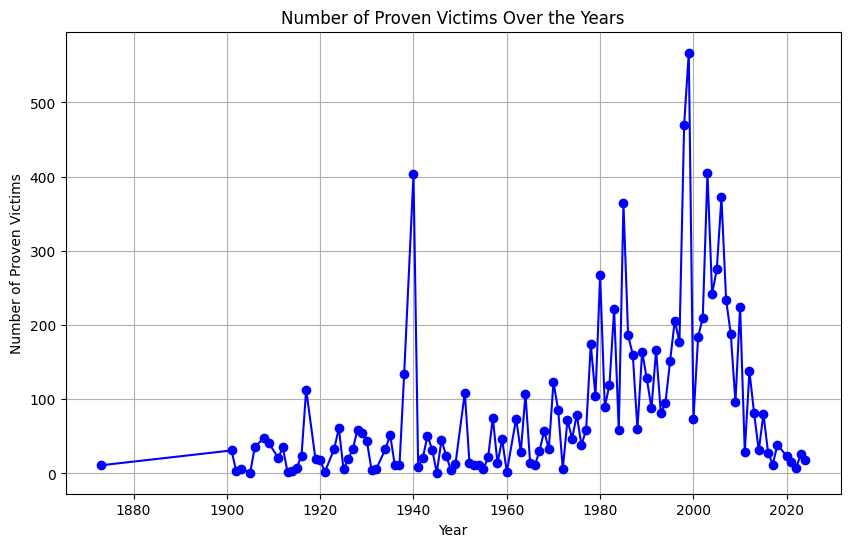

In [12]:
# Group by 'end' and sum 'proven_victims'
victims_per_year = df.groupby('End')['Proven victims'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(victims_per_year['End'], victims_per_year['Proven victims'], marker='o', linestyle='-', color='b')
plt.title('Number of Proven Victims Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Proven Victims')
plt.grid(True)
plt.show()

In [22]:
print(df[df['Start'] == df['Start'].max()]['Notes'])

140    Murdered 14 people at his home in Kigali, arre...
Name: Notes, dtype: object


In [23]:
 df.head()

,Name,Country,Proven victims,Possible victims,Notes,Start,End,duration,Latitude,Longitude
0,Luis Garavito,Colombia,193,300,"Child-murderer, torture-killer, and rapist kno...",1992,1999,7,4.0,-72.0
1,Pedro López,Colombia,110,300,"Child-murderer and rapist, known as ""The Monst...",1969,1980,11,4.0,-72.0
2,Javed Iqbal,Pakistan,100,100,"Child-murderer and rapist, known as ""Kukri"", I...",1998,1999,1,30.0,70.0
3,Mikhail Popkov,Russia,83,86,"Serial rapist-killer nicknamed ""The Werewolf"",...",1992,2010,18,60.0,100.0
4,Daniel Camargo Barbosa,Colombia,72,180,"Child and woman murderer, believed to have pos...",1974,1986,12,4.0,-72.0


# Questions
_________
1. Which countries have the most serial killers?
2. What 5 years had the most active number of serial killers?
3. How many active serial killers are there at any given time? 
    * group by year, average.
4. When where there the fewest active serial killers?
5. Is there a relationship between Country/Decade/Proven victims?

## 1. Which countries have the most serial killers?
**Note** Only considering first country listed for each serial killer

In [24]:
df.value_counts('Country')

Country
United States                       307
United Kingdom                       71
Russia                               32
South Africa                         29
Soviet Union                         26
                                   ... 
United States  Austria (alleged)      1
Uzbekistan                            1
United States  Portuguese Angola      1
Venezuela                             1
Yemen                                 1
Name: count, Length: 88, dtype: int64

# 2. What 5 Years had the most overlap? 

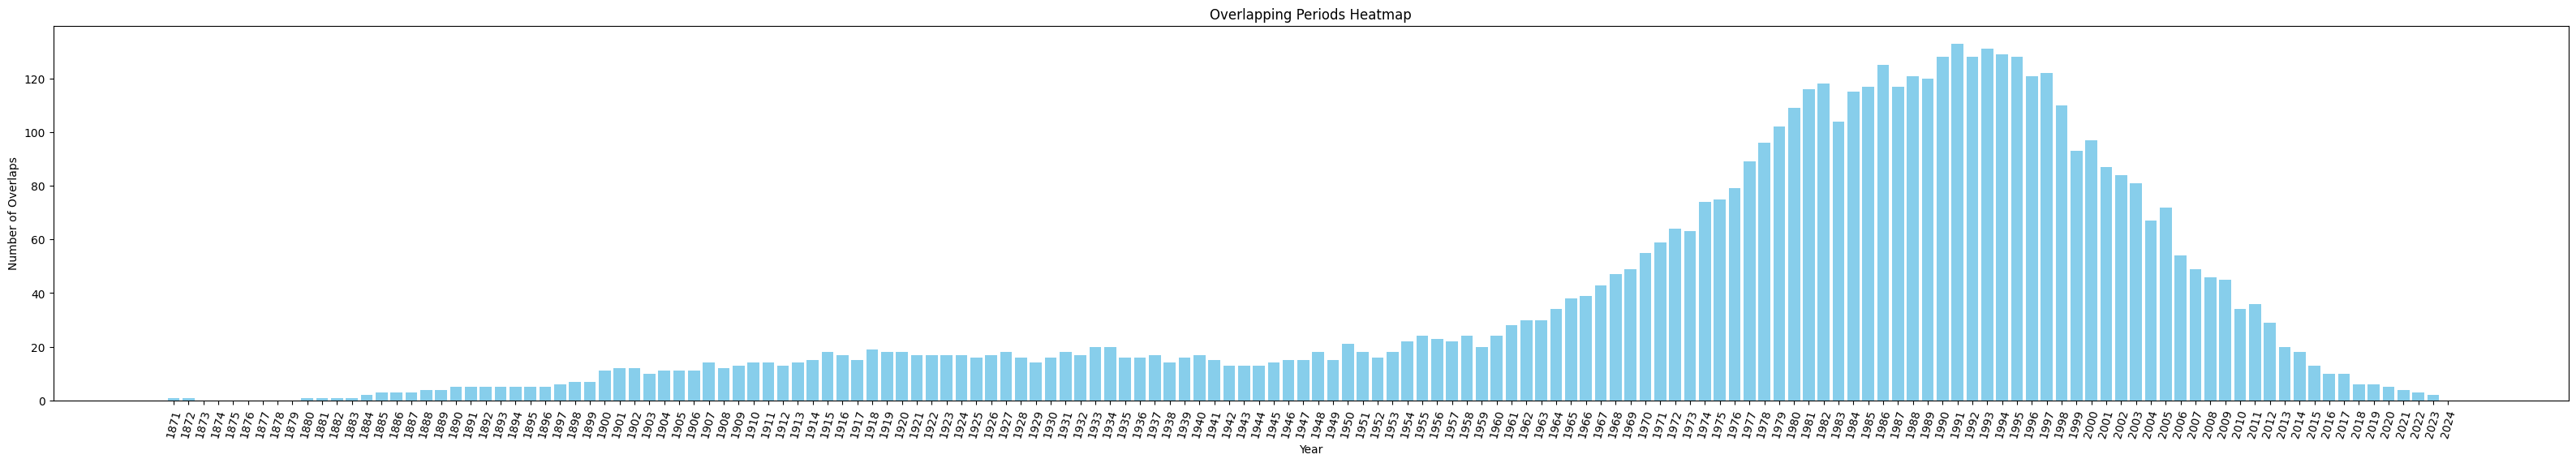

In [66]:
# Convert columns to datetime
df['Start'] = pd.to_datetime(df['Start'], format='%YYYY')
df['End'] = pd.to_datetime(df['End'], format='%YYYY')

# Create a date range from the minimum Start to the maximum End
date_range = pd.date_range(df['Start'].min(), df['End'].max(), freq='YS')

# Initialize overlap count array
overlap_counts = np.zeros(len(date_range))

# Count overlaps
for Start, End in zip(df['Start'], df['End']):
    overlap_counts[(date_range >= Start) & (date_range < End)] += 1

# Plot heatmap
plt.figure(figsize=(40, 6))
plt.bar(date_range.year, overlap_counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Overlaps')
plt.title('Overlapping Periods Heatmap')
plt.xticks(date_range.year, rotation=75)
plt.show()

## Top 10 as a table
Note that 1989-1997 are all in the top 10.  1986 is the only year outside of that span.

In [67]:
# Convert columns to datetime
df['Start'] = pd.to_datetime(df['Start'], format='%YYYY')
df['End'] = pd.to_datetime(df['End'], format='%YYYY')

# Generate a list of years from the minimum Start to the maximum End year
years = list(range(df['Start'].dt.year.min(), df['End'].dt.year.max() + 1))

# Initialize a DataFrame to store the results
active_serial_killers = pd.DataFrame({'year': years})

# Count the number of active serial killers for each year
active_serial_killers['active_serial_killers'] = active_serial_killers['year'].apply(
    lambda year: ((df['Start'].dt.year <= year) & (df['End'].dt.year >= year)).sum()
)

# Display the first few rows of the resulting DataFrame
active_serial_killers.sort_values('active_serial_killers', ascending=False).head(10)

,year,active_serial_killers
120,1991,147
121,1992,147
115,1986,146
122,1993,146
123,1994,146
124,1995,144
125,1996,144
119,1990,143
118,1989,139
126,1997,139


# 3. How many active serial killers are there at any given time? 

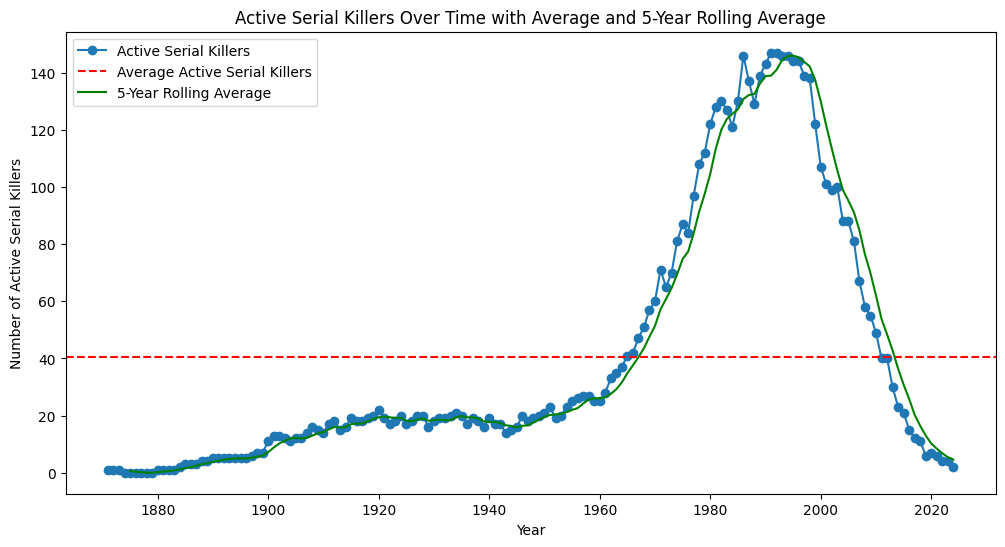

In [51]:

# Calculate the average number of active serial killers across all years
average_active = active_serial_killers['active_serial_killers'].mean()

# Calculate the rolling average based on the previous 5 years
active_serial_killers['rolling_avg'] = active_serial_killers['active_serial_killers'].rolling(window=5).mean()

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(active_serial_killers['year'], active_serial_killers['active_serial_killers'], label='Active Serial Killers', marker='o')
plt.axhline(average_active, color='r', linestyle='--', label='Average Active Serial Killers')
plt.plot(active_serial_killers['year'], active_serial_killers['rolling_avg'], label='5-Year Rolling Average', color='g')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Active Serial Killers')
plt.title('Active Serial Killers Over Time with Average and 5-Year Rolling Average')
plt.legend()

# Show plot
plt.show()


# How many serial killers are have been active recently?

In [53]:
active_serial_killers.sort_values('year', ascending=False).head(10)

,year,active_serial_killers,rolling_avg
153,2024,2,4.6
152,2023,4,5.4
151,2022,4,6.8
150,2021,6,8.4
149,2020,7,10.2
148,2019,6,13.0
147,2018,11,16.4
146,2017,12,20.2
145,2016,15,25.8
144,2015,21,30.8


# Proven Victims per killer per decade

In [56]:
victims_per_year.head()

,End,Proven victims
0,1873-01-01,11
1,1901-01-01,31
2,1902-01-01,3
3,1903-01-01,6
4,1905-01-01,1


,End,Proven victims
0,1873-01-01,11.0
1,1901-01-01,31.0
2,1902-01-01,3.0
3,1903-01-01,3.0
4,1905-01-01,1.0


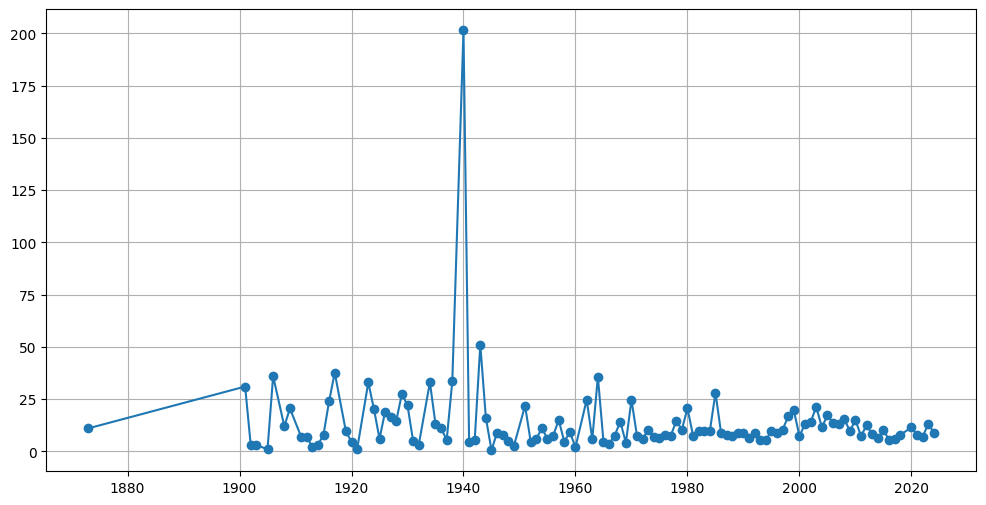

In [60]:
victims_per_year = df.groupby('End')['Proven victims'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(victims_per_year['End'], victims_per_year['Proven victims'], label='Proven victims', marker='o')

plt.grid()
victims_per_year.head()

In [64]:
victims_per_year.sort_values('End', ascending=False).head()

,End,Proven victims
114,2024-01-01,9.0
113,2023-01-01,13.0
112,2022-01-01,7.0
111,2021-01-01,8.0
110,2020-01-01,11.5


# 5. Is there a relationship between Country/Decade/Proven victims?

In [74]:
df['End'] = df['End'].dt.strftime('%Y')
df['Start'] = df['Start'].dt.strftime('%Y')

df.head()


,Name,Country,Proven victims,Possible victims,Notes,Start,End,duration,Latitude,Longitude
0,Luis Garavito,Colombia,193,300,"Child-murderer, torture-killer, and rapist kno...",1992,1999,7,4.0,-72.0
1,Pedro López,Colombia,110,300,"Child-murderer and rapist, known as ""The Monst...",1969,1980,11,4.0,-72.0
2,Javed Iqbal,Pakistan,100,100,"Child-murderer and rapist, known as ""Kukri"", I...",1998,1999,1,30.0,70.0
3,Mikhail Popkov,Russia,83,86,"Serial rapist-killer nicknamed ""The Werewolf"",...",1992,2010,18,60.0,100.0
4,Daniel Camargo Barbosa,Colombia,72,180,"Child and woman murderer, believed to have pos...",1974,1986,12,4.0,-72.0


In [81]:
for year in sorted(df['End'].unique()):
    print(year)

1873
1901
1902
1903
1905
1906
1908
1909
1911
1912
1913
1914
1915
1916
1917
1919
1920
1921
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1934
1935
1936
1937
1938
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2020
2021
2022
2023
2024


In [84]:
df[df['End'] == '1873']

# create a new column called 'decade' and assign the decade of the 'End' year to it
df['decade'] = df['End'].astype(int) // 10 * 10
df.head()

,Name,Country,Proven victims,Possible victims,Notes,Start,End,duration,Latitude,Longitude,decade
0,Luis Garavito,Colombia,193,300,"Child-murderer, torture-killer, and rapist kno...",1992,1999,7,4.0,-72.0,1990
1,Pedro López,Colombia,110,300,"Child-murderer and rapist, known as ""The Monst...",1969,1980,11,4.0,-72.0,1980
2,Javed Iqbal,Pakistan,100,100,"Child-murderer and rapist, known as ""Kukri"", I...",1998,1999,1,30.0,70.0,1990
3,Mikhail Popkov,Russia,83,86,"Serial rapist-killer nicknamed ""The Werewolf"",...",1992,2010,18,60.0,100.0,2010
4,Daniel Camargo Barbosa,Colombia,72,180,"Child and woman murderer, believed to have pos...",1974,1986,12,4.0,-72.0,1980


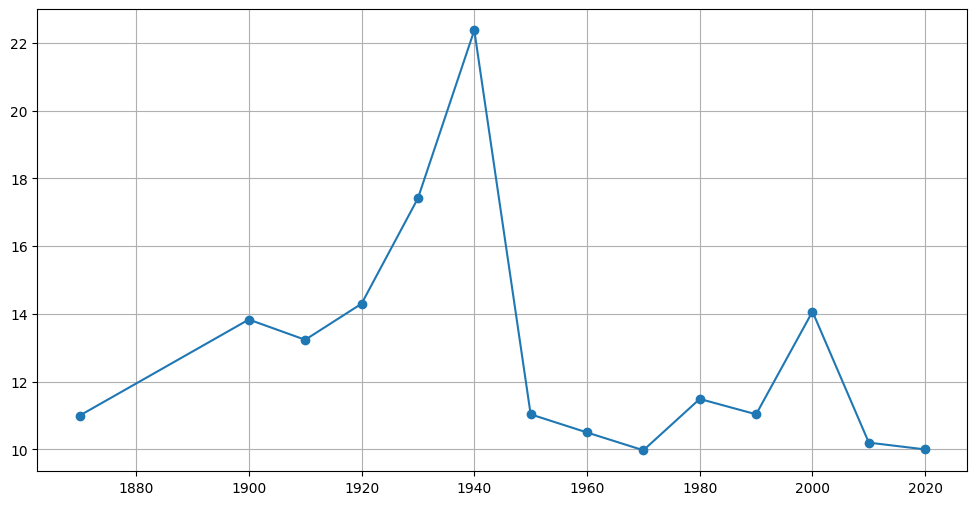

In [85]:
victims_per_decade = df.groupby('decade')['Proven victims'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(victims_per_decade['decade'], victims_per_decade['Proven victims'], label='Proven victims', marker='o')

plt.grid()
plt.show()

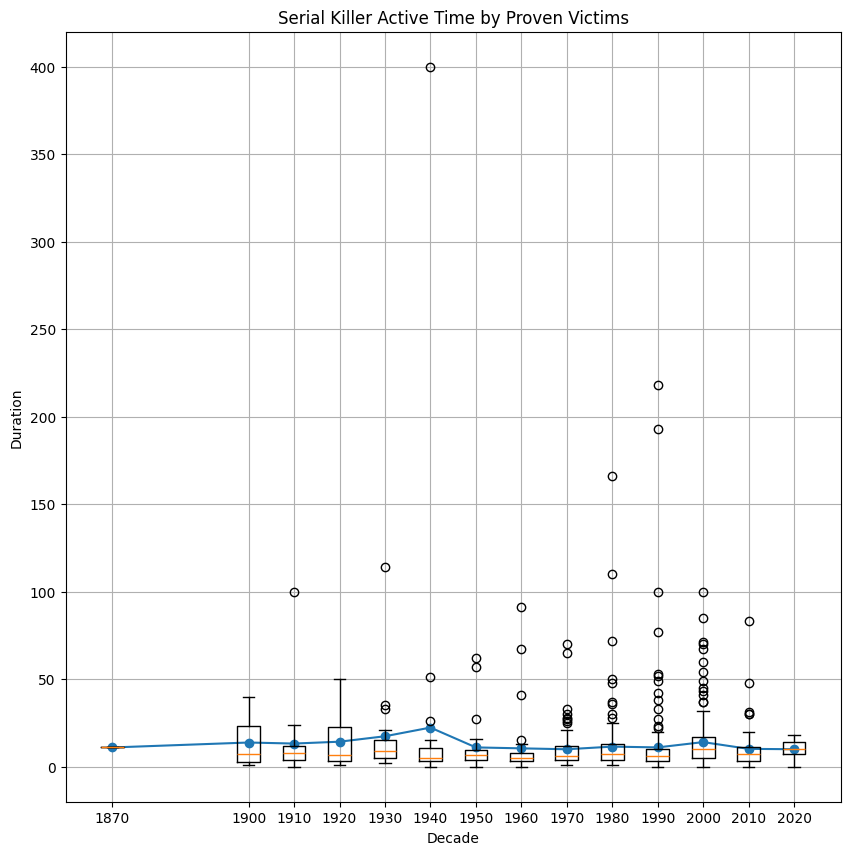

In [97]:
duration_by_decade = df.groupby('decade')['Proven victims'].mean().reset_index()

plt.figure(figsize=(10, 10))
plt.plot(duration_by_decade['decade'], duration_by_decade['Proven victims'], label='Duration', marker='o')
# Create a boxplot for each decade
plt.boxplot(df.groupby('decade')['Proven victims'].apply(list), positions=duration_by_decade['decade'], widths=5)

# Add labels and title
plt.xlabel('Decade')
plt.ylabel('Duration')
plt.title('Serial Killer Active Time by Proven Victims')

# Show plot
plt.grid()
plt.show()